# Fixed vs ARM Loan Comparison (API Example)

This notebook demonstrates how to use the `mortgagemodeler` Python API to compare a traditional fixed-rate mortgage with a variety of adjustable-rate mortgages (ARMs), including:

- 3/1 ARM
- 5/1 and 5/5 ARMs
- 7/6 and 7/1 ARMs
- 10/6 and 10/1 ARMs

We will:

- Generate amortization schedules for each loan type
- Visualize payment trajectories and cumulative interest
- Calculate total cost to exit after 5 years
- Analyze the tradeoffs between fixed and adjustable-rate structures

Parameters

In [3]:
from mortgagemodeler import Loan, LoanAmortizer
from datetime import date
from decimal import Decimal
import pandas as pd

In [4]:

# Exit month horizon (e.g. 5 years)
exit_month = 60

# ARM forward curve for comparison
forward_curve = {
    "2029-01-01": 6.75,
    "2030-01-01": 7.25,
    "2031-01-01": 7.75,
}

# ARM configurations: (Label, ARM Type, Margin, Starting Rate)
arm_configs = [
    ("3/1 ARM",  "3/1", 2.5, Decimal("5.875")),
    ("5/1 ARM",  "5/1", 2.5, Decimal("6.000")),
    ("5/5 ARM",  "5/5", 2.5, Decimal("6.250")),
    ("7/6 ARM",  "7/6", 2.5, Decimal("6.375")),
    ("10/6 ARM", "10/6", 2.5, Decimal("6.500")),
]

# Create fixed-rate loan
fixed_loan = Loan(
    principal=Decimal("500000"),
    term_months=360,
    rate=Decimal("6.625"),
    origination_date=date(2024, 1, 1),
    loan_type="fixed"
)
fixed_amort = LoanAmortizer(fixed_loan)
fixed_df = fixed_amort.to_dataframe()
fixed_df["Loan Type"] = "Fixed-Rate"

# Compute fixed loan exit cost
fixed_total = fixed_df.loc[fixed_df["Month"] <= exit_month, "Total Payment"].sum()
fixed_balance = fixed_df.loc[fixed_df["Month"] == exit_month, "Ending Balance"].values[0]
fixed_exit_cost = fixed_total + fixed_balance

# Start results with fixed loan
results = [("Fixed-Rate", round(fixed_exit_cost, 2))]

# Loop through ARM configs
for label, arm_type, margin, rate in arm_configs:
    arm = Loan.from_arm(
        principal=Decimal("500000"),
        term=360,
        arm_type=arm_type,
        index="SOFR",
        margin=margin,
        rate=rate,
        origination_date=date(2024, 1, 1),
        caps=(2, 1, 5),
        floors=(0, 0, 0),
        forward_curve=forward_curve
    )
    amort = LoanAmortizer(arm, custom_rate_schedule=forward_curve)
    df = amort.to_dataframe()
    df["Loan Type"] = label

    total_paid = df.loc[df["Month"] <= exit_month, "Total Payment"].sum()
    remaining_balance = df.loc[df["Month"] == exit_month, "Ending Balance"].values[0]
    exit_cost = total_paid + remaining_balance

    results.append((label, round(exit_cost, 2)))


⚠️  RateReader: File not found at /opt/anaconda3/lib/python3.12/site-packages/mortgagemodeler/utils/../data/macroeconforward.txt. Falling back to static index + margin logic.
⚠️  RateReader: File not found at /opt/anaconda3/lib/python3.12/site-packages/mortgagemodeler/utils/../data/macroeconforward.txt. Falling back to static index + margin logic.
⚠️  RateReader: File not found at /opt/anaconda3/lib/python3.12/site-packages/mortgagemodeler/utils/../data/macroeconforward.txt. Falling back to static index + margin logic.
⚠️  RateReader: File not found at /opt/anaconda3/lib/python3.12/site-packages/mortgagemodeler/utils/../data/macroeconforward.txt. Falling back to static index + margin logic.
⚠️  RateReader: File not found at /opt/anaconda3/lib/python3.12/site-packages/mortgagemodeler/utils/../data/macroeconforward.txt. Falling back to static index + margin logic.


In [7]:
import pandas as pd

# Convert results into a DataFrame
exit_df = pd.DataFrame(results, columns=["Loan Type", "Cost to Exit at 5 Years"])

# Sort by cost to exit
exit_df = exit_df.sort_values("Cost to Exit at 5 Years").reset_index(drop=True)

# Display the table
exit_df


,Loan Type,Cost to Exit at 5 Years
0,3/1 ARM,642008.53
1,5/1 ARM,645136.97
2,5/5 ARM,651401.34
3,7/6 ARM,654537.19
4,10/6 ARM,657675.27
5,Fixed-Rate,660815.63


# What This Shows:

Shorter initial fixed periods (like 3/1 or 5/1 ARMs) save the most in a 5-year exit scenario.

Longer ARMs (10/6) and fixed-rate loans are more expensive before rate resets even kick in.

⚠️  RateReader: File not found at /opt/anaconda3/lib/python3.12/site-packages/mortgagemodeler/utils/../data/macroeconforward.txt. Falling back to static index + margin logic.
⚠️  RateReader: File not found at /opt/anaconda3/lib/python3.12/site-packages/mortgagemodeler/utils/../data/macroeconforward.txt. Falling back to static index + margin logic.
⚠️  RateReader: File not found at /opt/anaconda3/lib/python3.12/site-packages/mortgagemodeler/utils/../data/macroeconforward.txt. Falling back to static index + margin logic.
⚠️  RateReader: File not found at /opt/anaconda3/lib/python3.12/site-packages/mortgagemodeler/utils/../data/macroeconforward.txt. Falling back to static index + margin logic.
⚠️  RateReader: File not found at /opt/anaconda3/lib/python3.12/site-packages/mortgagemodeler/utils/../data/macroeconforward.txt. Falling back to static index + margin logic.


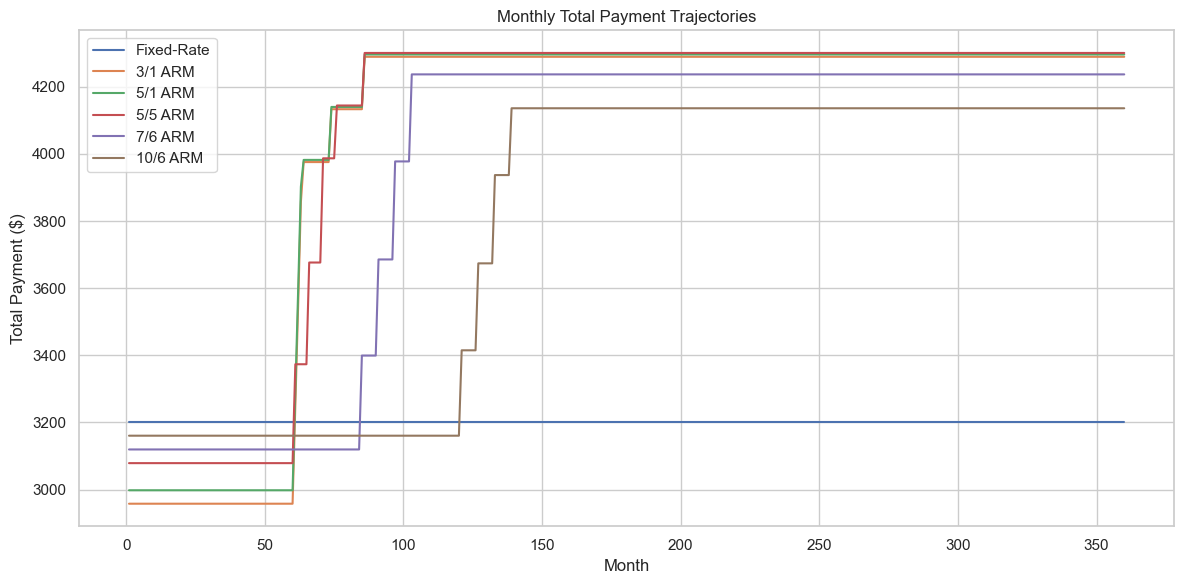

In [10]:
from mortgagemodeler import Loan, LoanAmortizer
from datetime import date
from decimal import Decimal
import matplotlib.pyplot as plt

# Shared loan parameters
principal = Decimal("500000")
term = 360
origination_date = date(2024, 1, 1)

# Forward curve for ARM index rates
forward_curve = {
    "2029-01-01": 6.75,
    "2030-01-01": 7.25,
    "2031-01-01": 7.75,
}

# Define ARM loan types with labels, types, margins, and rates
arm_configs = [
    ("3/1 ARM",  "3/1", 2.5, Decimal("5.875")),
    ("5/1 ARM",  "5/1", 2.5, Decimal("6.000")),
    ("5/5 ARM",  "5/5", 2.5, Decimal("6.250")),
    ("7/6 ARM",  "7/6", 2.5, Decimal("6.375")),
    ("10/6 ARM", "10/6", 2.5, Decimal("6.500")),
]

# Create fixed-rate loan
fixed = Loan(
    principal=principal,
    rate=Decimal("6.625"),
    term_months=term,
    origination_date=origination_date,
    loan_type="fixed"
)

# Create ARM loans
arms = []
for label, arm_type, margin, rate in arm_configs:
    arm = Loan.from_arm(
        principal=principal,
        term=term,
        arm_type=arm_type,
        index="SOFR",
        margin=margin,
        rate=rate,
        origination_date=origination_date,
        caps=(2, 1, 5),
        floors=(0, 0, 0),
        forward_curve=forward_curve
    )
    arms.append((label, arm))

# Generate amortization schedules
loans = [("Fixed-Rate", fixed)] + arms
schedules = [(name, LoanAmortizer(loan, custom_rate_schedule=forward_curve).to_dataframe()) for name, loan in loans]

# Plot total monthly payments over time
plt.figure(figsize=(12, 6))
for name, df in schedules:
    plt.plot(df["Month"], df["Total Payment"], label=name)
plt.title("Monthly Total Payment Trajectories")
plt.xlabel("Month")
plt.ylabel("Total Payment ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


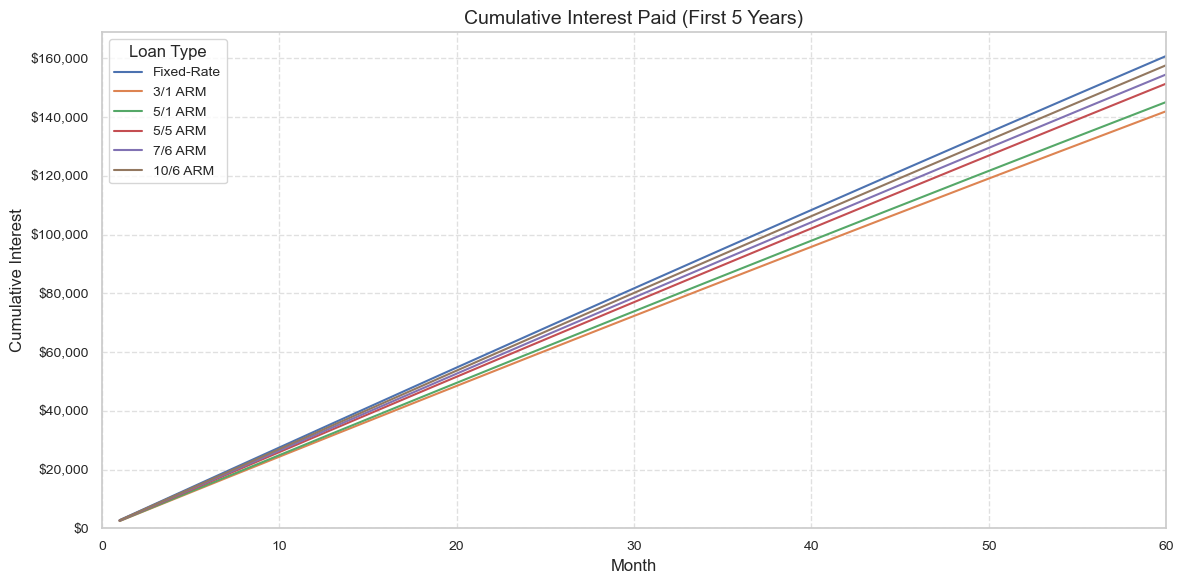

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 6))

max_interest = 0  # track global max

for name, df in schedules:
    df["Cumulative Interest"] = df["Interest"].cumsum()
    plt.plot(df["Month"], df["Cumulative Interest"], label=name)
    max_val = df.loc[df["Month"] == 60, "Cumulative Interest"].values[0]
    max_interest = max(max_interest, max_val)

plt.title("Cumulative Interest Paid (First 5 Years)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Cumulative Interest", fontsize=12)

plt.xlim(0, 60)
plt.ylim(0, max_interest * 1.05)  # add 5% headroom for spacing
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Format y-axis as currency
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Loan Type", fontsize=10)
plt.tight_layout()
plt.show()


In [14]:
exit_costs = []

for name, df in schedules:
    five_year_df = df[df["Month"] <= 60]
    total_paid = five_year_df["Total Payment"].sum()
    final_balance = five_year_df.iloc[-1]["Ending Balance"]
    total_cost = total_paid + final_balance
    exit_costs.append((name, total_paid, final_balance, total_cost))

exit_df = pd.DataFrame(exit_costs, columns=[
    "Loan Type", "Payments Made", "Balance Remaining", "Total Cost to Exit"
])
exit_df = exit_df.round(2)

# Print clean table
print("### Total Cost to Exit After 5 Years")
print(exit_df.sort_values("Total Cost to Exit").to_markdown(index=False))


### Total Cost to Exit After 5 Years
| Loan Type   |   Payments Made |   Balance Remaining |   Total Cost to Exit |
|:------------|----------------:|--------------------:|---------------------:|
| 3/1 ARM     |          177461 |              464547 |               642009 |
| 5/1 ARM     |          179865 |              465272 |               645137 |
| 5/5 ARM     |          184715 |              466686 |               651401 |
| 7/6 ARM     |          187161 |              467376 |               654537 |
| 10/6 ARM    |          189620 |              468055 |               657675 |
| Fixed-Rate  |          192093 |              468723 |               660816 |
